Importing required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.

## Loading all files

In [5]:
#run only once, no need to run if directory already exisits

#create directories as required by YOLO 
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/labels', exist_ok=True)
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)

In [3]:
#run only once, no need to run if directory already exisits

# name the paths
img_folder_1 = 'keggle_img_dataset_renamed'
img_folder_2 = 'self_gathered_data/new_images'
label_folder = 'self_gathered_data/all_labels'
output_img_train = 'dataset/images/train'
output_img_val = 'dataset/images/val'
output_label_train = 'dataset/labels/train'
output_label_val = 'dataset/labels/val'



# Gather all image and label paths
img_files = []
for folder in [img_folder_1, img_folder_2]:
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.JPG'):
            img_files.append(os.path.join(folder, file))

label_files = [os.path.join(label_folder, file) for file in os.listdir(label_folder) if file.endswith('.txt')]

print(f"loaded {len(img_files)} image files")
print(f"loaded {len(label_files)} label files")

#data cleaning
#map img files to txt files (label files have the same name as image files)
img_to_label = {os.path.splitext(os.path.basename(img))[0]: img for img in img_files}
label_dict = {os.path.splitext(os.path.basename(label))[0]: label for label in label_files}

print(f"loaded {len(img_to_label)} valid img files")
print(f"loaded {len(label_dict)} valid labels files")


loaded 377 image files
loaded 377 label files
loaded 377 valid img files
loaded 377 valid labels files


## Spliting into Train-Test sets

In [20]:
#run only once, no need to run if files already split

# Helper function to extract class info from filenames
## this preparation is because the numbers of samples for different classes are unbalanced (some has 90+ while some only has 60+)
## we need to do stratified splitting later to ensure balanced representation in our split 
def extract_class_from_filename(filename):
    return filename.split('(')[0]  # Extracts everything before '('

# Filter to include only images with labels and group them by class
from collections import defaultdict
class_img_label_dict = defaultdict(list)
for img_name, img_path in img_to_label.items():
    if img_name in label_dict:
        class_name = extract_class_from_filename(img_name)
        class_img_label_dict[class_name].append((img_path, label_dict[img_name]))


#check the sample number for each class
for class_name, pairs in class_img_label_dict.items():
    print(f"Class '{class_name}' has {len(pairs)} samples")

Class 'GreenLeafHopper ' has 69 samples
Class 'PlantHopper ' has 66 samples
Class 'RiceBug ' has 95 samples
Class 'RiceLeafRoller ' has 77 samples
Class 'RiceStemBorer ' has 70 samples


In [26]:


#perform train-test split
from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_labels, val_labels = [], [], [], []

for class_name, pairs in class_img_label_dict.items():
    imgs, labels = zip(*pairs)
    imgs_train, imgs_val, labels_train, labels_val = train_test_split(
        imgs, 
        labels, 
        test_size=0.2, 
        random_state=42)
    train_imgs.extend(imgs_train)
    val_imgs.extend(imgs_val)
    train_labels.extend(labels_train)
    val_labels.extend(labels_val)

#for checking and debugging
from collections import Counter
# Count samples in train and validation splits by class
train_class_counts = Counter([extract_class_from_filename(os.path.basename(img)) for img in train_imgs])
val_class_counts = Counter([extract_class_from_filename(os.path.basename(img)) for img in val_imgs])

# Print the counts for each class in train and validation sets
for class_name in train_class_counts.keys() | val_class_counts.keys():
    train_count = train_class_counts.get(class_name, 0)
    val_count = val_class_counts.get(class_name, 0)
    print(f"{class_name}: \n{train_count} images for training, {val_count} images for validation")

RiceLeafRoller : 
61 samples for training, 16 samples for validation
PlantHopper : 
52 samples for training, 14 samples for validation
GreenLeafHopper : 
55 samples for training, 14 samples for validation
RiceStemBorer : 
56 samples for training, 14 samples for validation
RiceBug : 
76 samples for training, 19 samples for validation


In [27]:
# copy images and labels to train/val folders
for img_path, label_path in zip(train_imgs, train_labels):
    shutil.copy(img_path, output_img_train)
    shutil.copy(label_path, output_label_train)

for img_path, label_path in zip(val_imgs, val_labels):
    shutil.copy(img_path, output_img_val)
    shutil.copy(label_path, output_label_val)

## Loading image with bounding box

In [2]:
#set the paths to labels and images directory
label_dir= "dataset/labels"
image_dir="dataset/images"

In [ ]:
#no need to run, just for debug

#visualize first two sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 1:
        break

### Creating Text files for labels
Creating Dataframes from txt files

In [11]:
boundbox_data_train=[] 

for filepath in glob.glob(label_dir+"/train/*.txt"):
    with open(filepath, 'r') as file:
        image_id = filepath.split('/')[-1].replace('.txt', '')  # Extract the image ID from filename
        
        for line in file:
            values = line.strip().split()  # Split by whitespace
            label = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])
            
            # Append the data to the list
            boundbox_data_train.append({
                'image_id': image_id,
                'label': label,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })

print (f"{len(boundbox_data_train)} files processed for train set")

boundbox_data_val=[] 

for filepath in glob.glob(label_dir+"/val/*.txt"):
    with open(filepath, 'r') as file:
        image_id = filepath.split('/')[-1].replace('.txt', '')  # Extract the image ID from filename
        
        for line in file:
            values = line.strip().split()  # Split by whitespace
            label = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])
            
            # Append the data to the list
            boundbox_data_val.append({
                'image_id': image_id,
                'label': label,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })

print (f"{len(boundbox_data_val)} files processed for validation set")

# Create DataFrames
train_df=pd.DataFrame(boundbox_data_train)
val_df=pd.DataFrame(boundbox_data_val)

306 files processed for train set
81 files processed for validation set


Because some images contain more than one pest, we print the results in the dataframe to see how many pest samples we accuallty have for each class.

In [12]:
# Count the samples for each class in the training set
train_class_counts = train_df['label'].value_counts()

# Count the samples for each class in the validation set
val_class_counts = val_df['label'].value_counts()

# Print the results
print("Class Distribution in Training Set:")
for label, count in train_class_counts.items():
    print(f"Class {label}: {count} samples")

print("\nClass Distribution in Validation Set:")
for label, count in val_class_counts.items():
    print(f"Class {label}: {count} samples")

Class Distribution in Training Set:
Class 2: 77 samples
Class 3: 63 samples
Class 0: 57 samples
Class 4: 56 samples
Class 1: 53 samples

Class Distribution in Validation Set:
Class 2: 18 samples
Class 4: 17 samples
Class 3: 17 samples
Class 0: 15 samples
Class 1: 14 samples


Visualizing one of the image in train set with the bounding box

Loading image at dataset/images\train\RiceBug (12).jpg
got corrdinates 192 8 273 397


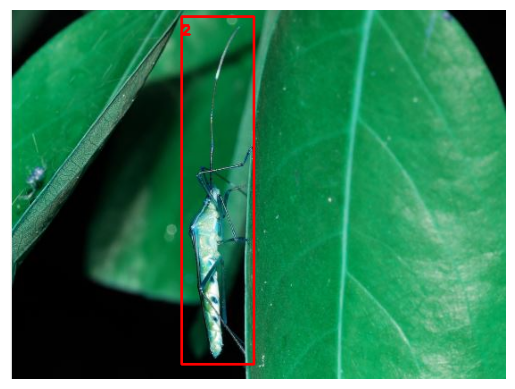

In [14]:
#no need to run, for debugging

index= 112 #picture to visualize

#read the img
image_path=os.path.join(image_dir, train_df["image_id"][index]+".jpg")
image = cv2.imread(image_path, 1)
print(f"Loading image at {image_path}")

if image is None:
    print("Error: Unable to load image with .jpg, trying .JPG")
    image = cv2.imread(os.path.join(image_dir, train_df["image_id"][index]+".JPG"), 1)

image_path = os.path.join(image_dir, "train", train_df["image_id"][index] + ".jpg")
if image is None:
    print(f"Error: Unable to load image at {image_path}")

# Get image dimensions
height, width, _ = image.shape

# Normalize bounding box coordinates (assumes YOLO format)
x_center = train_df['x_center'][index] * width
y_center = train_df['y_center'][index] * height
box_width = train_df['width'][index] * width
box_height = train_df['height'][index] * height

# Calculate the top-left and bottom-right corners of the bounding box
xmin = int(x_center - (box_width / 2))
ymin = int(y_center - (box_height / 2))
xmax = int(x_center + (box_width / 2))
ymax = int(y_center + (box_height / 2))

print ("got corrdinates", xmin, ymin, xmax, ymax)


# Draw rectangle
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (xmin, ymin+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

other things to do: 
- change the labels from numbers to names
- data cleaning